在实践中，当给定相同的查询、键和值的集合时，我们希望模型可以基于相同的注意力机制学习到不同的行为，然后将不同的行为作为知识组合起来，捕获序列内各种范围的依赖关系（例如，短距离依赖和长距离依赖关系）。因此，允许注意力机制组合使用查询、键和值的不同 子空间表示（representation subspaces）可能是有益的。

为此，与其只使用单独一个注意力汇聚，我们可以用独立学习得到的h组不同的 线性投影（linear projections）来变换查询、键和值。然后，这h组变换后的查询、键和值将并行地送到注意力汇聚中。最后，将这h个注意力汇聚的输出拼接在一起，并且通过另一个可以学习的线性投影进行变换，以产生最终输出。这种设计被称为多头注意力（multihead attention）(Vaswani et al., 2017)。对于h个注意力汇聚输出，每一个注意力汇聚都被称作一个头（head）。图10.5.1 展示了使用全连接层来实现可学习的线性变换的多头注意力。
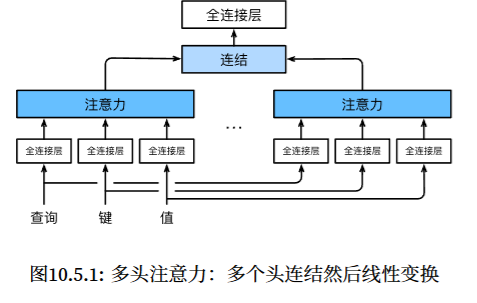

In [1]:
import torch
import math
from torch import nn
from d2l import torch as d2l

In [3]:
#为了能够使多个头并行计算，上面的MultiHeadAttention类将使用下面定义的两个转置函数。具体来说，transpose_output函数反转了transpose_qkv函数的操作。
#@save
def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
    # 输出X的形状:(batch_size，查询或者“键－值”对的个数，num_heads，
    # num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
    # 输出X的形状:(batch_size，num_heads，查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)
    # 最终输出的形状:(batch_size*num_heads,查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])
#@save
def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [4]:
#@save
class MultiHeadAttention(nn.Module):
    """多头注意力"""
    def __init__(self,key_size,query_size,value_size,num_hiddens,num_heads,dropout,bias=False,**kwargs):
        super(MultiHeadAttention,self).__init__(**kwargs)
        self.num_heads=num_heads
        self.attention=d2l.DotProductAttention(dropout)
        self.W_q=nn.Linear(query_size,num_hiddens,bias=bias)
        self.W_k=nn.Linear(key_size,num_hiddens,bias=bias)
        self.W_v=nn.Linear(value_size,num_hiddens,bias=bias)
        self.W_o=nn.Linear(num_hiddens,num_hiddens,bias=bias)
    def forward(self,queries,keys,values,valid_lens):
        #queries，keys，values的形状:
        #(batch_size，查询或者“键－值”对的个数，num_hiddens)
        #valid_lens 的形状:
        #(batch_size，)或(batch_size，查询的个数)
        #经过变换后，输出的queries，keys，values 的形状:
        #(batch_size*num_heads，查询或者“键－值”对的个数，
        #num_hiddens/num_heads)
        queries=transpose_qkv(self.W_q(queries),self.num_heads)
        keys=transpose_qkv(self.W_k(keys),self.num_heads)
        values=transpose_qkv(self.W_v(values),self.num_heads)
        if valid_lens is not None:
            # 在轴0，将第一项（标量或者矢量）复制num_heads次，
            # 然后如此复制第二项，然后诸如此类。
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)
        
        #output的形状:(batch_size*num_heads，查询的个数，num_hiddens/num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        #output_concat的形状:(batch_size，查询的个数，num_hiddens)
        output_concat=transpose_output(output,self.num_heads)
        return self.W_o(output_concat)


In [5]:
#用键和值相同的例子来测试MultiHeadAttention类
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                               num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [6]:
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens = 6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

小结
- 多头注意力融合了来自于多个注意力汇聚的不同知识，这些知识的不同来源于相同的查询、键和值的不同的子空间表示。
- 基于适当的张量操作，可以实现多头注意力的并行计算。